# Week 12 Problem 3

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says YOUR CODE HERE. Do not write your answer in anywhere else other than where it says YOUR CODE HERE. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select Kernel, and restart the kernel and run all cells (Restart & Run all).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select File → Save and CheckPoint)

5. When you are ready to submit your assignment, go to Dashboard → Assignments and click the Submit button. Your work is not submitted until you click Submit.

6. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.

7. If your code does not pass the unit tests, it will not pass the autograder.

**NOTE:** If you get Error `TweepError: Twitter error response: status code = 429`, wait for few minutes before continuing. This may occur during validation as well.


## Author: Apurv Garg
### Primary Reviewer: Radhir Kothuri


# Due Date: 6 PM, April 16, 2018

In [1]:
from nose.tools import assert_equal, assert_true, assert_false, assert_almost_equal
import numpy.testing as npt
import tweepy as tw
% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations
import string
import networkx as nx
import matplotlib as mpl
# These two lines suppress warnings that sometimes
# occur when making visualizations
import warnings
warnings.filterwarnings('ignore')


# Twitter Authentication

In the code cell below, the `twitter.cred` file, that was created for previous assignment is used.
If your twitter credentials are not working, just regenerate the tokens under `Keys and Access Tokens` tab on twitter apps.

In [2]:
tokens = []
# Order: Access Token, Access Token Secret, Consumer Key, Consumer SecretAccess
with open("/home/data_scientist/twitter.cred", 'r') as fin:
    for line in fin:
        if line[0] != '#': # Not a comment line
            tokens.append(line.rstrip('\n'))

auth = tw.OAuthHandler(tokens[2], tokens[3])
auth.set_access_token(tokens[0], tokens[1])
api = tw.API(auth, wait_on_rate_limit=True)
user = api.me()
print("Twitter Screen Name: ", user.screen_name)


Twitter Screen Name:  daisiran


# Problem 1

For this problem, complete the function `pairs` which will take `num_tweets`, `search`, `id1`, `id2` and `pairs` as parameters and return the set of unique hashtags and most common pairs and the counts of each pair(pair, count) in that order.<br>

- Get the tweets and build list for the search results
- Extract hashtags, strip off leading '#', remove trailing punctuation and turn all characters to lowercase.
    - Sort the list of tags to ensure the Counter works correctly
- Build set of tokens and make a list of tag pairs. Find count for each paried tag.

**NOTE:** since_id and max_id are the parameters for tweepy Cursor.
> since_id : specifies the tweet id starting from which tweets should be fetched. <br>
> max_id : specifies the tweet id till which tweets should be fetched.

In [3]:
def pairs(num_tweets, search, id1, id2, pairs):
    '''           
    Parameters
    ----------
    num_tweets : Number of tweets to fetch
    search : Search term
    id1 : value for since_id parameter in tweepy Cursor
    id2 : value for max_id parameter in tweepy Cursor
    pairs : most common tokens
    
    Returns
    -------
    A tuple of 2 containing the set of unique hashtags, 
    most common pairs and the counts of each pair(pair, count)

    top_tkns will look something like this:
    ---------------------------------------
    {'ai', 'analytics', 'bigdata', 'datascience', 'iot'}

    top_pairs will look something like this:
    ----------------------------------------
    [(('analytics', 'iot'), 53),
     (('analytics', 'bigdata'), 52),
     (('bigdata', 'datascience'), 45),
     (('ai', 'bigdata'), 43)]
    '''
    # YOUR CODE HERE
    tweets = []
    # Get the tweets
    results = tw.Cursor(api.search, q=search).items(num_tweets)
    # Build list from Twitter search results
    for result in results:
        tweets.append(result.text)
    tkns = set()
    cnt = Counter()
    # Iterate over all tweets
    for tweet in tweets:
        # First, we use a list comprehension that extract hashtags
        # We strip off leading '#', then remove trailing punctuation.
        # And turn all characters to lowercase.
        # Note this is not Unicode clean.
        # Finally, we sort the list of tags (which will ensure the
        # Counter works correctly)

        tags = sorted([tag.lstrip("#").rstrip(string.punctuation).lower() 
                for tag in tweet.split() if tag.startswith("#")])

        # We now build our set of tokens

        for tag in tags:
            tkns.add(tag)

        # Next we use combinations from the itertools library 
        # to make a list of tag pairs. 
        # We then increment the counter for each paried tag

        for paired_tags in combinations(tags, 2):
            cnt[paired_tags] += 1
    # Extract the top pair, list of tuples (pair, count)
    top_pairs = cnt.most_common(pairs)[0]

    # Now we go through pair counter for top pairs to build a network.

    top_tkns = set()
    num_top_pairs = pairs

    # Get most common pairs
    top_pairs = cnt.most_common(num_top_pairs)

    # Get most frequenly used tokens
    for pair, count in top_pairs:
        top_tkns.add(pair[0])
        top_tkns.add(pair[1])
    return top_tkns, top_pairs

In [4]:
token1, pairs1=pairs(500, '#analytics' , 981676660083871744, 981712192268414977, 4)
assert_equal(len(token1)>=3, True)
assert_equal('analytics' in token1, True)
assert_equal(len(pairs1), 4)
token2, pairs2=pairs(200, '#bigdata', 981737540150546433, 981743245838471169, 3)
assert_equal('bigdata' in token2, True)
assert_equal(len(token2)>=3, True)
assert_equal(len(pairs2), 3)

# Problem 2

For this problem, complete the function `graph` which will take `token` and `pairs` as parameters and return the axes object and graph object<br>

The following is expected in the function: <br>
- Creating a figure and axes object using subplots from matplotlib.<br>
- Creating a graph object from networkx<br>
- Node shape in draw_networkx_nodes should be Circular('o')<br>
- Use spectral_layout for the graph
- Use normalized weights (scale to minimum weight)
- Draw weighted edges
- label nodes to the default labels
- Set a title for your plot.<br>

If done correctly your plot should look *similar* to the graphs below:

g1 | g2
- | - 
![Imgur](https://i.imgur.com/GhYQNJK.png) | ![Imgur](https://i.imgur.com/mVYcIwZ.png)


In [9]:
def graph(token, pairs):
    '''           
    Parameters
    ----------
    token : set of unique hashtags[returned from Problem1]
    pairs : most common pairs and the counts of each pair(pair, count)[returned from Problem1]
    
    Returns
    -------
    A tuple of 2 containing axes object, 
    Graph object
    '''

    # YOUR CODE HERE
    # First setup the current figure. 
    # No Axes, no Axes labels, white background

    fig, axs = plt.subplots()

    clrs = sns.color_palette("Paired")

    sns.set(style='white', font_scale=1.5)

    # Build graph

    import networkx as nx

    g = nx.Graph()

    g.add_nodes_from(list(token))

    for pair, count in pairs:
        g.add_edge(pair[0], pair[1], weight=count)

    # Now draw graph, use circular layout

    pos = nx.spectral_layout(g)

    nx.draw_networkx_nodes(g, pos, with_labels=True,
                           node_size = 3000,
                           node_color=clrs[2],
                           node_shape='o',
                           alpha = 0.4)

    # Build up list of edges and weights for controlled plotting
    edges = []
    weights = []

    for n1, n2, dct in g.edges(data=True):
        edges.append((n1, n2))
        weights.append(dct['weight'])

    # Make normalized weights (scale to minimum weight)
    min_weight = min(weights)
    norm_weights = [int(weight/min_weight) for weight in weights]

    # Draw weighted edges, we pass in the edgelist so we can 
    # also pass in the edge weights individually
    nx.draw_networkx_edges(g, pos, edgelist=edges, 
                           width = norm_weights, 
                           edge_color=clrs.as_hex()[4],
                           alpha = 0.6)

    # Now label nodes, since we don't provide lables, it uses the 
    # default labels (which is what we want)
    nx.draw_networkx_labels(g, pos, font_size = 18,
                            font_color = clrs[1],
                            alpha = 1.0)

    axs.set_title('Hashtag Co-Occurance Plot')
    axs.set_xticklabels([])
    axs.set_yticklabels([])

    sns.despine(top = True, bottom = True, 
                left = True, right = True)
    return axs, g

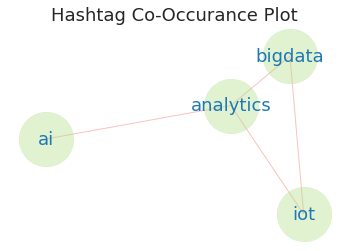

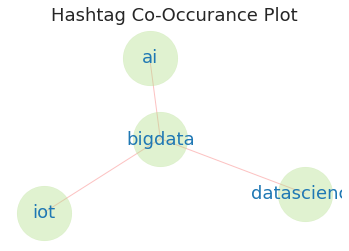

In [10]:
axs1, g1 = graph(token1, pairs1)
axs2, g2 = graph(token2, pairs2)
assert_true(isinstance(axs1, mpl.axes._subplots.Axes), msg='return an axes object')
assert_false(axs1.get_title() == '', msg='Set Your title')
assert_true(isinstance(axs2, mpl.axes._subplots.Axes), msg='return an axes object')
assert_false(axs2.get_title() == '', msg='Set Your title')
assert_equal('analytics' in g1.nodes(), True)
assert_equal('bigdata' in g2.nodes(), True)
assert_true(isinstance(g1, nx.classes.graph.Graph))
assert_true(isinstance(g2, nx.classes.graph.Graph))

# Problem 3

For this problem, complete the function `properties` which will take `graph` as parameter and return the graph's radius, diameter, eccentricity, center, number of edges and number of nodes. <br>

In [15]:
def properties(graph):
    '''           
    Parameters
    ----------
    graph : Graph object[returned from Problem2]

    Returns
    -------
    A tuple of 6 containing the radius, 
    diameter,
    eccentricity,
    center,
    number of edges,
    number of nodes
    '''    

    # YOUR CODE HERE
    rad = nx.radius(graph)
    dia = nx.diameter(graph)
    ecc = nx.eccentricity(graph)
    ctr = nx.center(graph)
    edg = graph.size()
    nodes = graph.order()
    return rad, dia, ecc, ctr, edg, nodes


In [16]:
rad1, dia1, ecc1, ctr1, edg1, nodes1 = properties(g1)
assert_true(2*rad1, dia1)
assert_equal('analytics' in ctr1, True)
assert_equal(edg1, 4)
assert_equal(nodes1>=3, True)
assert_equal(ecc1['analytics']>=1, True)

rad2, dia2, ecc2, ctr2, edg2, nodes2 = properties(g2)
assert_true(2*rad2, dia2)
assert_equal('bigdata' in ctr2, True)
assert_equal(edg2, 3)
assert_equal(nodes2>=2, True)
assert_equal(ecc2['bigdata']>=1, True)